In [61]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [62]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [63]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38675,2022-03-01T21:22:14.615Z,60.952300,-151.257700,0.00,2.20,ml,NaN,NaN,NaN,0.9100,...,2022-03-01T21:26:42.710Z,"14 km SSW of Tyonek, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
38676,2022-03-01T21:16:45.780Z,39.425333,-110.319667,-1.21,1.42,md,5.0,192.00,0.004385,0.0400,...,2022-03-01T22:46:44.500Z,"15 km SSE of Sunnyside, Utah",earthquake,1.33,0.22,0.212,4.0,reviewed,uu,uu
38677,2022-03-01T21:08:58.910Z,38.835167,-122.800003,2.22,0.85,md,11.0,77.00,0.008209,0.0100,...,2022-03-01T21:26:18.107Z,"7km WNW of Cobb, CA",earthquake,0.40,0.90,NaN,1.0,automatic,nc,nc
38678,2022-03-31T21:00:50.670Z,38.821499,-122.793167,3.21,0.35,md,10.0,90.00,0.012760,0.0100,...,2022-03-31T21:02:26.715Z,"6km NNW of The Geysers, CA",earthquake,0.63,1.10,NaN,1.0,automatic,nc,nc


In [64]:
#drop duplicates in postgres data
model_df.drop_duplicates(subset=['id'], inplace=True)
print(model_df)

                           time   latitude   longitude   depth   mag magType  \
0      2022-01-06T01:42:39.855Z  37.384000 -117.107500    1.10  1.30      ml   
1      2022-01-06T01:31:33.698Z  38.181000 -117.818000    7.30  1.40      ml   
2      2022-01-06T01:24:20.083Z  61.340700 -149.885200   30.00  1.50      ml   
3      2022-01-06T01:15:15.851Z  62.870300 -150.762500  111.30  2.10      ml   
4      2022-01-06T01:10:44.629Z  64.014500 -148.765700    1.90  1.50      ml   
...                         ...        ...         ...     ...   ...     ...   
38675  2022-03-01T21:22:14.615Z  60.952300 -151.257700    0.00  2.20      ml   
38676  2022-03-01T21:16:45.780Z  39.425333 -110.319667   -1.21  1.42      md   
38677  2022-03-01T21:08:58.910Z  38.835167 -122.800003    2.22  0.85      md   
38678  2022-03-31T21:00:50.670Z  38.821499 -122.793167    3.21  0.35      md   
38679  2022-03-26T01:25:27.831Z -20.535000 -177.562400  490.64  4.40      mb   

        nst     gap      dmin     rms  

In [65]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38675,2022-03-01 21:22:14.615000+00:00,60.952300,-151.257700,0.00,2.20,ml,NaN,NaN,NaN,0.9100,...,2022-03-01T21:26:42.710Z,"14 km SSW of Tyonek, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
38676,2022-03-01 21:16:45.780000+00:00,39.425333,-110.319667,-1.21,1.42,md,5.0,192.00,0.004385,0.0400,...,2022-03-01T22:46:44.500Z,"15 km SSE of Sunnyside, Utah",earthquake,1.33,0.22,0.212,4.0,reviewed,uu,uu
38677,2022-03-01 21:08:58.910000+00:00,38.835167,-122.800003,2.22,0.85,md,11.0,77.00,0.008209,0.0100,...,2022-03-01T21:26:18.107Z,"7km WNW of Cobb, CA",earthquake,0.40,0.90,NaN,1.0,automatic,nc,nc
38678,2022-03-31 21:00:50.670000+00:00,38.821499,-122.793167,3.21,0.35,md,10.0,90.00,0.012760,0.0100,...,2022-03-31T21:02:26.715Z,"6km NNW of The Geysers, CA",earthquake,0.63,1.10,NaN,1.0,automatic,nc,nc


In [66]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [67]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix Time


In [68]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.384000,-117.107500,1.10,1.30,1.641433e+09
1,38.181000,-117.818000,7.30,1.40,1.641433e+09
2,61.340700,-149.885200,30.00,1.50,1.641432e+09
3,62.870300,-150.762500,111.30,2.10,1.641432e+09
4,64.014500,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
38675,60.952300,-151.257700,0.00,2.20,1.646170e+09
38676,39.425333,-110.319667,-1.21,1.42,1.646169e+09
38677,38.835167,-122.800003,2.22,0.85,1.646169e+09
38678,38.821499,-122.793167,3.21,0.35,1.648760e+09


In [69]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [70]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [71]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [72]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['mag'], axis = 1)

y = cleaned_df_dropped[['mag']]

In [73]:
#checking number of columns and rows for each feature
X.shape, y.shape

((38674, 4), (38674, 1))

In [74]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [75]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 0.3557116253299344, 	R2 score: 0.7889002334364277, 	Model score: 0.7889002334364277
n_estimators=3:
	Mean Squared Error: 0.3119024829021295, 	R2 score: 0.8148991018492382, 	Model score: 0.8148991018492382
n_estimators=4:
	Mean Squared Error: 0.28589292078897277, 	R2 score: 0.8303346740923871, 	Model score: 0.8303346740923871
n_estimators=5:
	Mean Squared Error: 0.2741189907503132, 	R2 score: 0.8373220023260132, 	Model score: 0.8373220023260132
n_estimators=6:
	Mean Squared Error: 0.267500343149646, 	R2 score: 0.8412498890296638, 	Model score: 0.8412498890296638
n_estimators=7:
	Mean Squared Error: 0.2618368478415215, 	R2 score: 0.8446109333485556, 	Model score: 0.8446109333485556
n_estimators=8:
	Mean Squared Error: 0.2581966802578756, 	R2 score: 0.8467712184571662, 	Model score: 0.8467712184571662
n_estimators=9:
	Mean Squared Error: 0.2543643485491646, 	R2 score: 0.8490455448257596, 	Model score: 0.8490455448257596
n_estimators=10:
	Mean Squared E

In [76]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 0.3557116253299344, 	R2: 0.7889002334364277, 	Model score: 0.7889002334364277
n_estimators=3:
	Mean Squared Error: 0.3119024829021295, 	R2: 0.8148991018492382, 	Model score: 0.8148991018492382
n_estimators=4:
	Mean Squared Error: 0.28589292078897277, 	R2: 0.8303346740923871, 	Model score: 0.8303346740923871
n_estimators=5:
	Mean Squared Error: 0.2741189907503132, 	R2: 0.8373220023260132, 	Model score: 0.8373220023260132
n_estimators=6:
	Mean Squared Error: 0.267500343149646, 	R2: 0.8412498890296638, 	Model score: 0.8412498890296638
n_estimators=7:
	Mean Squared Error: 0.2618368478415215, 	R2: 0.8446109333485556, 	Model score: 0.8446109333485556
n_estimators=8:
	Mean Squared Error: 0.2581966802578756, 	R2: 0.8467712184571662, 	Model score: 0.8467712184571662
n_estimators=9:
	Mean Squared Error: 0.2543643485491646, 	R2: 0.8490455448257596, 	Model score: 0.8490455448257596
n_estimators=10:
	Mean Squared Error: 0.25290331925968546, 	R2: 0.84991260375774

In [77]:
#save best model
import joblib

filename = r'/Users/rosaicelaroman/Desktop/portfolio_work/mag_model.sav'
joblib.dump(best_model, filename)


['/Users/rosaicelaroman/Desktop/portfolio_work/mag_model.sav']

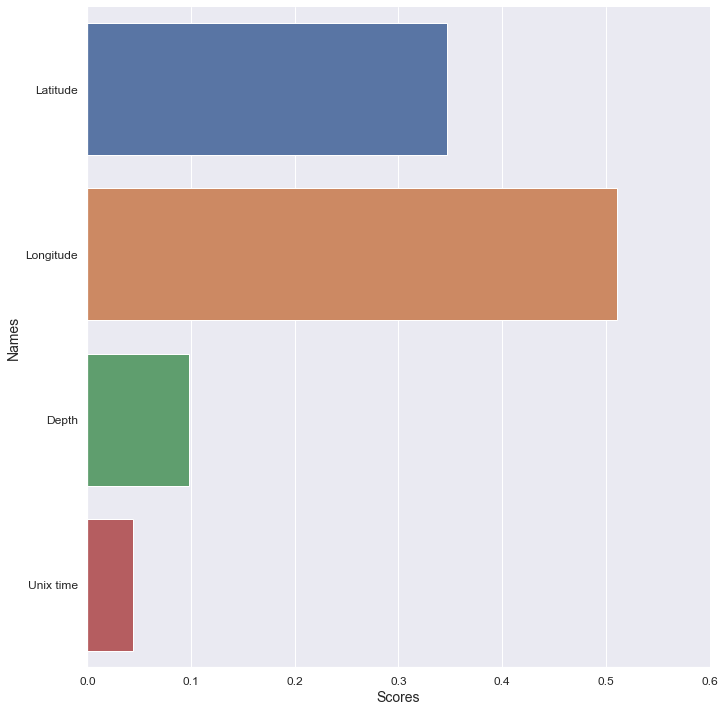

In [78]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['latitude', 'longitude', 'depth', 'Unix Time']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [79]:
#define number of splits for cross-validation
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 3868  3869  3870 ... 38671 38672 38673] | test: [   0    1    2 ... 3865 3866 3867]
Train: [    0     1     2 ... 38671 38672 38673] | test: [3868 3869 3870 ... 7733 7734 7735]
Train: [    0     1     2 ... 38671 38672 38673] | test: [ 7736  7737  7738 ... 11601 11602 11603]
Train: [    0     1     2 ... 38671 38672 38673] | test: [11604 11605 11606 ... 15469 15470 15471]
Train: [    0     1     2 ... 38671 38672 38673] | test: [15472 15473 15474 ... 19336 19337 19338]
Train: [    0     1     2 ... 38671 38672 38673] | test: [19339 19340 19341 ... 23203 23204 23205]
Train: [    0     1     2 ... 38671 38672 38673] | test: [23206 23207 23208 ... 27070 27071 27072]
Train: [    0     1     2 ... 38671 38672 38673] | test: [27073 27074 27075 ... 30937 30938 30939]
Train: [    0     1     2 ... 38671 38672 38673] | test: [30940 30941 30942 ... 34804 34805 34806]
Train: [    0     1     2 ... 34804 34805 34806] | test: [34807 34808 34809 ... 38671 38672 38673]


In [80]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[-0.36652292 -0.36945413 -0.37811151 -0.37862498 -0.37212676 -0.36197361
 -0.36760588 -0.38056096 -0.35839841 -0.34756233]
MAE: -0.368 (0.010)


In [81]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [82]:
#create elements for plot validation curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

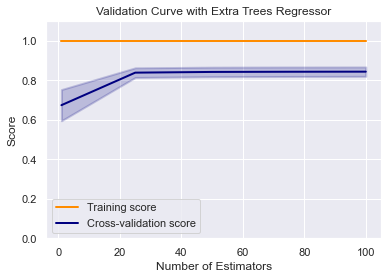

In [83]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [84]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_mag = y_test
mags = actual_mag['mag'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(mags, testpredict)
test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 0.483
MAE: 0.352


In [85]:
#make dataframe with actual test values and ML predicted ones
mag_pred = actual_mag
mag_pred['Predicted'] = testpredict


In [86]:
mag_pred_all = mag_pred.rename(columns={'mag': 'Actual'})
mag_pred_all

,Actual,Predicted
31109,3.30,3.372449
27837,1.58,1.341122
5591,1.60,2.439694
21969,4.60,4.259184
35589,2.09,1.823878
...,...,...
3822,2.50,2.491735
6029,0.12,0.593367
28514,1.99,2.113367
29955,2.75,1.824388


In [87]:
#join dataframes for actual and predicted with original dataframe
mag_pred_all = mag_pred.merge(model_df, how='inner', left_index=True, right_index=True)
mag_pred_all


,mag_x,Predicted,time,latitude,longitude,depth,mag_y,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
31109,3.30,3.372449,2022-03-25 16:00:55.679000+00:00,56.351600,-148.781200,10.00,3.30,ml,NaN,251.0,...,"254 km SE of Chiniak, Alaska",earthquake,10.80,2.00,0.057000,40.0,reviewed,us,us,1.648224e+09
27837,1.58,1.341122,2022-02-19 14:10:13.970000+00:00,38.771333,-122.710167,1.84,1.58,md,26.0,72.0,...,"2km WSW of Anderson Springs, CA",earthquake,0.25,0.22,0.002000,2.0,reviewed,nc,nc,1.645280e+09
5591,1.60,2.439694,2021-12-16 17:25:21.244000+00:00,54.649600,-163.397900,25.40,1.60,ml,NaN,NaN,...,"Unimak Island region, Alaska",earthquake,NaN,1.40,NaN,NaN,reviewed,ak,ak,1.639676e+09
21969,4.60,4.259184,2022-02-10 13:20:40.227000+00:00,-6.497700,129.931000,150.46,4.60,mb,NaN,41.0,...,Banda Sea,earthquake,8.60,8.60,0.110000,25.0,reviewed,us,us,1.644499e+09
35589,2.09,1.823878,2022-03-11 15:03:17.330000+00:00,34.229167,-80.543000,1.19,2.09,md,10.0,87.0,...,"6 km ESE of Camden, South Carolina",earthquake,0.63,3.18,0.014000,5.0,reviewed,se,se,1.647011e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,2.50,2.491735,2021-12-21 21:46:46.811000+00:00,44.367600,-115.153500,10.00,2.50,ml,NaN,61.0,...,"23 km NW of Stanley, Idaho",earthquake,2.40,2.00,0.059000,38.0,reviewed,us,us,1.640123e+09
6029,0.12,0.593367,2021-12-15 09:49:26.220000+00:00,33.587167,-116.805000,7.89,0.12,ml,12.0,160.0,...,"13km WNW of Anza, CA",earthquake,0.23,0.33,0.102000,5.0,reviewed,ci,ci,1.639562e+09
28514,1.99,2.113367,2022-02-17 21:00:20.390000+00:00,19.332500,-155.164333,5.01,1.99,md,42.0,85.0,...,"14 km SSE of Volcano, Hawaii",earthquake,0.28,0.76,0.142247,21.0,reviewed,hv,hv,1.645132e+09
29955,2.75,1.824388,2022-03-29 12:41:40.700000+00:00,19.508500,-155.677000,5.11,2.75,ml,16.0,142.0,...,"20 km ENE of Honaunau-Napoopoo, Hawaii",earthquake,0.54,0.81,0.159620,12.0,reviewed,hv,hv,1.648558e+09


In [88]:
#rename columns
mag_pred_all = mag_pred_all.rename(columns={'mag_x': 'Actual', 'mag_y': 'mag'})
mag_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
31109,3.30,3.372449,2022-03-25 16:00:55.679000+00:00,56.351600,-148.781200,10.00,3.30,ml,NaN,251.0,...,"254 km SE of Chiniak, Alaska",earthquake,10.80,2.00,0.057000,40.0,reviewed,us,us,1.648224e+09
27837,1.58,1.341122,2022-02-19 14:10:13.970000+00:00,38.771333,-122.710167,1.84,1.58,md,26.0,72.0,...,"2km WSW of Anderson Springs, CA",earthquake,0.25,0.22,0.002000,2.0,reviewed,nc,nc,1.645280e+09
5591,1.60,2.439694,2021-12-16 17:25:21.244000+00:00,54.649600,-163.397900,25.40,1.60,ml,NaN,NaN,...,"Unimak Island region, Alaska",earthquake,NaN,1.40,NaN,NaN,reviewed,ak,ak,1.639676e+09
21969,4.60,4.259184,2022-02-10 13:20:40.227000+00:00,-6.497700,129.931000,150.46,4.60,mb,NaN,41.0,...,Banda Sea,earthquake,8.60,8.60,0.110000,25.0,reviewed,us,us,1.644499e+09
35589,2.09,1.823878,2022-03-11 15:03:17.330000+00:00,34.229167,-80.543000,1.19,2.09,md,10.0,87.0,...,"6 km ESE of Camden, South Carolina",earthquake,0.63,3.18,0.014000,5.0,reviewed,se,se,1.647011e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,2.50,2.491735,2021-12-21 21:46:46.811000+00:00,44.367600,-115.153500,10.00,2.50,ml,NaN,61.0,...,"23 km NW of Stanley, Idaho",earthquake,2.40,2.00,0.059000,38.0,reviewed,us,us,1.640123e+09
6029,0.12,0.593367,2021-12-15 09:49:26.220000+00:00,33.587167,-116.805000,7.89,0.12,ml,12.0,160.0,...,"13km WNW of Anza, CA",earthquake,0.23,0.33,0.102000,5.0,reviewed,ci,ci,1.639562e+09
28514,1.99,2.113367,2022-02-17 21:00:20.390000+00:00,19.332500,-155.164333,5.01,1.99,md,42.0,85.0,...,"14 km SSE of Volcano, Hawaii",earthquake,0.28,0.76,0.142247,21.0,reviewed,hv,hv,1.645132e+09
29955,2.75,1.824388,2022-03-29 12:41:40.700000+00:00,19.508500,-155.677000,5.11,2.75,ml,16.0,142.0,...,"20 km ENE of Honaunau-Napoopoo, Hawaii",earthquake,0.54,0.81,0.159620,12.0,reviewed,hv,hv,1.648558e+09


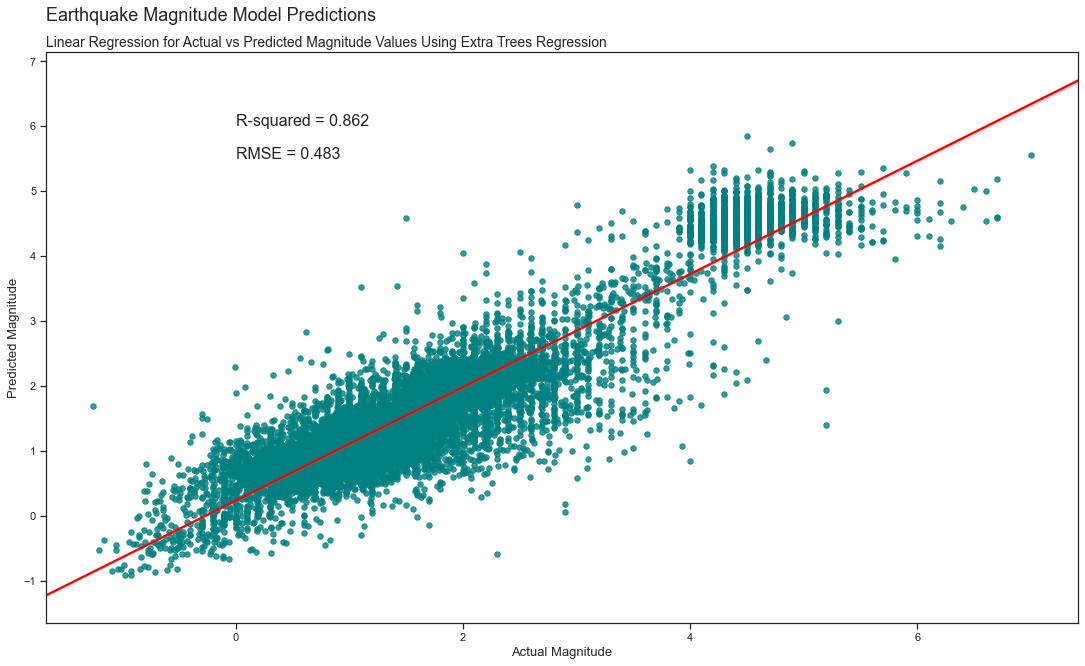

In [89]:
#plot actual vs predicted values
x = np.array(mag_pred_all['mag'])
y = np.array(testpredict)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Magnitude', fontsize=13)
plt.xlabel('Actual Magnitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Magnitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(mag_pred_all['mag'], testpredict)), (0, 6),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 5.5), fontsize=16)

fig.savefig('../static/images/extratrees_mag_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [90]:
# make a single prediction
from datetime import datetime
lat = float(input('Enter a latitude (in decimal form; negative for southern hemisphere): '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
date_input = input('Enter a date (yyyy/mm/dd): ')
time_input = input('Enter a time in UTC (HH:MM:SS): ')
datetime_str = date_input + ' '+ time_input
date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[lat,lon,depth,date_time_unix]]
y_pred = best_model.predict(single_features)
print('Predicted Magnitude: %g' % y_pred)

Predicted Magnitude: 4.62245


Test with new data from USGS

In [91]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-04-01T01:20:19.660Z,37.399334,-118.582336,13.80,1.73,md,7.0,154.0,0.04853,0.01,...,2022-04-01T01:28:11.185Z,"2km SE of Round Valley, CA",earthquake,3.61,7.26,0.040000,6.0,automatic,nc,nc
1,2022-04-01T01:08:14.709Z,-22.867000,170.565300,10.00,4.70,mb,NaN,107.0,2.89000,0.53,...,2022-04-01T01:24:35.040Z,southeast of the Loyalty Islands,earthquake,9.40,1.90,0.148000,17.0,reviewed,us,us
2,2022-04-01T01:04:35.470Z,19.239666,-155.394836,32.57,1.99,md,30.0,156.0,NaN,0.11,...,2022-04-01T01:07:58.310Z,"9 km ENE of Pāhala, Hawaii",earthquake,0.75,0.72,0.700000,7.0,automatic,hv,hv
3,2022-04-01T01:04:16.470Z,38.801666,-122.811333,0.74,0.83,md,16.0,68.0,0.01402,0.03,...,2022-04-01T01:05:52.375Z,"6km WNW of The Geysers, CA",earthquake,0.21,0.56,0.460000,2.0,automatic,nc,nc
4,2022-04-01T00:58:29.410Z,36.806667,-121.539169,5.52,2.71,md,57.0,36.0,0.03099,0.18,...,2022-04-01T01:39:20.260Z,"4km S of San Juan Bautista, CA",earthquake,0.26,0.46,0.130000,62.0,automatic,nc,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,2022-03-31T02:02:50.510Z,36.313833,-89.528167,9.46,1.56,md,21.0,46.0,0.03289,0.06,...,2022-03-31T16:09:19.820Z,southeastern Missouri,earthquake,0.42,0.60,0.089000,14.0,reviewed,nm,nm
279,2022-03-31T02:00:52.513Z,-33.508000,-72.307200,10.00,4.20,mwr,NaN,92.0,0.59700,0.77,...,2022-03-31T23:47:52.755Z,"65 km W of Cartagena, Chile",earthquake,4.20,1.90,0.068000,21.0,reviewed,us,us
280,2022-03-31T02:00:35.510Z,18.553500,-66.906167,17.56,2.76,md,24.0,208.0,NaN,0.23,...,2022-03-31T02:52:48.700Z,"9 km NNE of Quebradillas, Puerto Rico",earthquake,0.61,0.36,0.112958,20.0,reviewed,pr,pr
281,2022-03-31T01:51:54.050Z,38.787498,-122.748833,-0.06,0.94,md,19.0,82.0,0.01038,0.07,...,2022-03-31T03:46:15.528Z,"1km NNE of The Geysers, CA",earthquake,0.25,0.62,0.080000,4.0,automatic,nc,nc


In [92]:
#create unix time column
test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9

In [93]:
#dropped columns not needed
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df

,latitude,longitude,depth,mag,Unix Time
0,37.399334,-118.582336,13.80,1.73,1.648776e+09
1,-22.867000,170.565300,10.00,4.70,1.648775e+09
2,19.239666,-155.394836,32.57,1.99,1.648775e+09
3,38.801666,-122.811333,0.74,0.83,1.648775e+09
4,36.806667,-121.539169,5.52,2.71,1.648775e+09
...,...,...,...,...,...
278,36.313833,-89.528167,9.46,1.56,1.648692e+09
279,-33.508000,-72.307200,10.00,4.20,1.648692e+09
280,18.553500,-66.906167,17.56,2.76,1.648692e+09
281,38.787498,-122.748833,-0.06,0.94,1.648692e+09


In [94]:
#find if any column has NaNs
cleaned_test_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [95]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['mag'], axis = 1)

y_test_data = cleaned_test_df[['mag']]

In [96]:
#use best model to predict data
pred_data_y = best_model.predict(X_test_data)


In [97]:
#create dataframe with predicted values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data

,latitude,longitude,depth,mag,Unix Time,Predicted
0,37.399334,-118.582336,13.80,1.73,1.648776e+09,1.142551
1,-22.867000,170.565300,10.00,4.70,1.648775e+09,6.239796
2,19.239666,-155.394836,32.57,1.99,1.648775e+09,2.077143
3,38.801666,-122.811333,0.74,0.83,1.648775e+09,0.748469
4,36.806667,-121.539169,5.52,2.71,1.648775e+09,1.481327
...,...,...,...,...,...,...
278,36.313833,-89.528167,9.46,1.56,1.648692e+09,1.560000
279,-33.508000,-72.307200,10.00,4.20,1.648692e+09,4.247959
280,18.553500,-66.906167,17.56,2.76,1.648692e+09,2.871429
281,38.787498,-122.748833,-0.06,0.94,1.648692e+09,0.927857


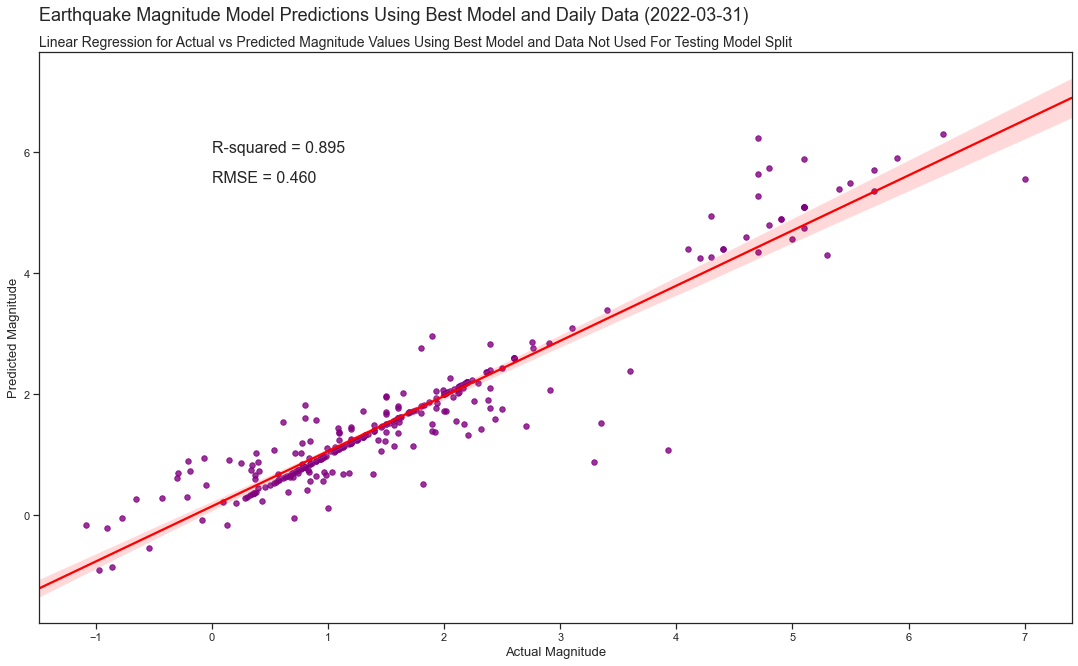

In [98]:
#create graph for actual vs predicted values
from datetime import date
today = date.today()

x = np.array(test_pred_data['mag'])
y = np.array(pred_data_y)
test_mse = mean_squared_error(x, y)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Magnitude', fontsize=13)
plt.xlabel('Actual Magnitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Magnitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 6),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 5.5), fontsize=16)

fig.savefig('../static/images/extratrees_mag_linear_sns_daily.png', bbox_inches='tight', dpi=600)
plt.show()

In [99]:
#create new tables in database with training/test dataset test values and predictions

#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
mag_pred_all.to_sql('earthquake_etrees_mag', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
mag_pred_all.to_sql('earthquake_etrees_mag', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()

Connected to database...
